In [1]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, TimestampType, StringType
from pyspark.sql.window import Window
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib

# spark initialization
spark = SparkSession.builder.appName("gamedata").getOrCreate()
hard_weekly_df = spark.read.parquet("../database/parquet/hard_weekly")

23/03/24 22:14:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
hard_weekly_df

DataFrame[begin_date: date, end_date: date, hw: string, units: int]

## 年単位の集計

年単位集計を行うために､yearカラムを追加｡値は end_dateを F.year()で変換する｡
なお､1998年のデータは年末だけなので､1999年以後でフィルタする｡

In [3]:
hard_weekly_year_df = hard_weekly_df.withColumn("year", F.year(F.col("end_date"))).filter(F.col("year") > 1998)

## グループ化して集計

年(year)ごと､ハード(hw)ごとにグループ化して集計する

In [4]:
hard_yearly_df = hard_weekly_year_df.groupBy("year", "hw").agg(
    F.sum(F.col("units")).alias("units")).sort("year")

In [5]:
# hard_yearly_df = hard_weekly_year_df.groupBy("year", "hw").sum("units").sort("year")
# aliasが通らないので面倒かも

## pivot化

pivotを使ってHW名を列に並べる｡縦軸は年｡値はunitsをそのまま用いる｡

縦軸にしたいカラムでgroupBy()して､横軸をpivot()に指定する｡
HWの表示順を調整するためにselectしておく

In [6]:
hard_yearly_pivot = hard_yearly_df.groupBy("year").pivot("hw").sum("units").sort("year").select(
    "year",
    "PS5", "XSX", "Switch",
    "XBOne", "PS4", "WiiU",
    "Vita", "3DS", 
    "Wii", "PS3", "XB360",
    "DS", "PSP",
    "Xbox", "GC", "GBA", "PS2",
    "WS", "PKS", "DC", "NeoGeoP",
    )

## pandas変換

pandasのplotでグラフ化するためpandasのDFに変換する｡

デフォルトだとindexが連番になるので､yearがindexになるようpandas側で調整する｡

In [7]:
hw_year = hard_yearly_pivot.toPandas().set_index("year")

23/03/24 22:14:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## グラフ化

面グラフを作成する

<AxesSubplot:xlabel='year'>

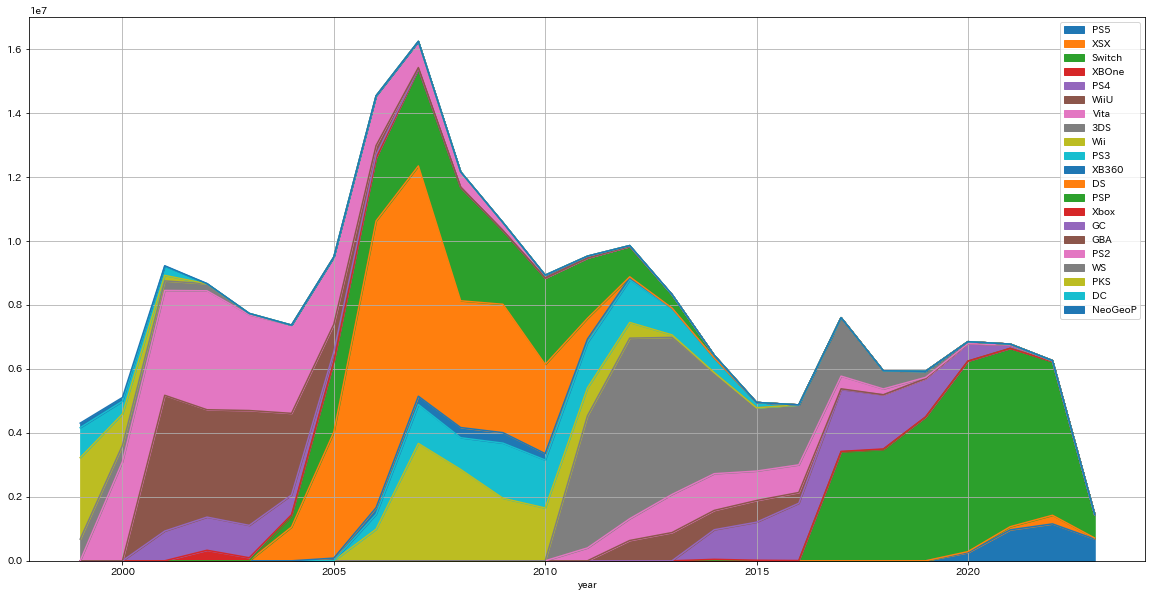

23/03/24 22:33:55 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 929201 ms exceeds timeout 120000 ms
23/03/24 22:33:55 WARN SparkContext: Killing executors is not supported by current scheduler.


In [8]:
hw_year.plot(figsize=(20,10), grid=True, kind="area", ylim=[0, 17000000])